## Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
Step 1: Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.

Step 2: From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
- Load Data
- Text Preprocessing
- EDA
- Feature Extraction
- Topic Modelling (Unsupervised)
- Model building using Supervised learning
- Model Training and evaluation
- Inference

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [3]:
import plotly
import matplotlib.pyplot as plt

In [5]:
!pip install pyLDAvis -qq

     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [6]:
!python -m spacy download en_core_web_md -qq

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-27 06:58:50.285376: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 42.8 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [7]:
import spacy
import pyLDAvis.gensim_models
#pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [8]:
root_path = "/content/drive/MyDrive/Assignment_Persistent/Client_data.json"

In [9]:
f = open(root_path)
data = json.load(f)

In [10]:
df = pd.json_normalize(data)

In [11]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [12]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [13]:
df1 = df[['_source.complaint_what_happened', '_source.product', '_source.sub_product',]]
df1.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [14]:
# Let's rename the column names
# product and sub_product columns are only used for verification purpose
# _source.complaint_what_happened	is used for topic modelling

df1 = df1.rename(columns = {"_source.complaint_what_happened":"complaint_text",
                          "_source.product":"category",
                          "_source.sub_product":"sub_category"})
df1.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [15]:
df1["complaint_text"] = df1["complaint_text"].str.replace("X","")

In [16]:
df1.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is and I appreciate it ...,Debt collection,Credit card debt
2,I upgraded my card in //2018 and was told by...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   complaint_text  78313 non-null  object
 1   category        78313 non-null  object
 2   sub_category    67742 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [18]:
# Our spaCy model:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM', 'X']
tokens = []
for complaint in nlp.pipe(df1['complaint_text']):
   proj_tok = [token.lemma_.lower() for token in complaint if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(proj_tok)

In [19]:
df1["tokens"] = tokens
df1["tokens"].head()

0                                                   []
1    [good, morning, appreciate, help, stop, chase,...
2    [upgrade, card, tell, agent, upgrade, annivers...
3                                                   []
4                                                   []
Name: tokens, dtype: object

In [20]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(df1["tokens"])

In [21]:
print(dictionary.token2id)

{'acceptable': 0, 'account': 1, 'advance': 2, 'appreciate': 3, 'ask': 4, 'attempt': 5, 'bank': 6, 'cardmember': 7, 'chase': 8, 'collect': 9, 'consumer': 10, 'debt': 11, 'good': 12, 'help': 13, 'information': 14, 'know': 15, 'mail': 16, 'month': 17, 'morning': 18, 'receive': 19, 'right': 20, 'send': 21, 'service': 22, 'statement': 23, 'stop': 24, 'thank': 25, 'validate': 26, 'verification': 27, 'write': 28, 'agent': 29, 'anniversary': 30, 'card': 31, 'change': 32, 'consent': 33, 'date': 34, 'give': 35, 'mislead': 36, 'order': 37, 'recording': 38, 'tell': 39, 'turn': 40, 'upgrade': 41, 'wrong': 42, 'applicant': 43, 'application': 44, 'credit': 45, 'extend': 46, 'fraudulent': 47, 'identity': 48, 'obtain': 49, 'report': 50, 'submit': 51, 'verify': 52, 'absolutely': 53, 'apply': 54, 'approve': 55, 'book': 56, 'come': 57, 'contact': 58, 'contrary': 59, 'correct': 60, 'decision': 61, 'deny': 62, 'error': 63, 'explain': 64, 'explicit': 65, 'fact': 66, 'get': 67, 'gets': 68, 'glad': 69, 'go': 7

In [22]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [23]:
corpus = [dictionary.doc2bow(doc) for doc in df1["tokens"]]

In [27]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=5, workers = 4, passes=10)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [28]:
lda_model.print_topics(-1)

[(0,
  '0.076*"account" + 0.047*"chase" + 0.045*"bank" + 0.032*"check" + 0.024*"money" + 0.020*"tell" + 0.016*"fund" + 0.015*"deposit" + 0.014*"day" + 0.014*"say"'),
 (1,
  '0.047*"chase" + 0.034*"loan" + 0.031*"payment" + 0.026*"mortgage" + 0.020*"pay" + 0.015*"home" + 0.013*"time" + 0.013*"year" + 0.011*"bank" + 0.011*"month"'),
 (2,
  '0.048*"chase" + 0.021*"receive" + 0.020*"send" + 0.018*"claim" + 0.016*"letter" + 0.015*"provide" + 0.015*"information" + 0.014*"dispute" + 0.014*"call" + 0.013*"contact"'),
 (3,
  '0.090*"credit" + 0.042*"account" + 0.041*"report" + 0.041*"chase" + 0.040*"payment" + 0.024*"balance" + 0.018*"pay" + 0.017*"card" + 0.013*"late" + 0.012*"debt"'),
 (4,
  '0.087*"card" + 0.053*"chase" + 0.052*"charge" + 0.039*"credit" + 0.016*"purchase" + 0.015*"fee" + 0.014*"tell" + 0.013*"call" + 0.013*"receive" + 0.011*"offer"')]

In [29]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [30]:
df1['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df1['complaint_text']))]
df1.head()

,complaint_text,category,sub_category,tokens,topic
0,,Debt collection,Credit card debt,[],0
1,Good morning my name is and I appreciate it ...,Debt collection,Credit card debt,"[good, morning, appreciate, help, stop, chase,...",0
2,I upgraded my card in //2018 and was told by...,Credit card or prepaid card,General-purpose credit card or charge card,"[upgrade, card, tell, agent, upgrade, annivers...",0
3,,Mortgage,Conventional home mortgage,[],0
4,,Credit card or prepaid card,General-purpose credit card or charge card,[],0


In [31]:
df['topic'] = df1['topic']
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided,topic
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided,0
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,0
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,0
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided,0
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A,0


In [32]:
df.topic.value_counts()

0    74145
1     2710
2     1120
3      272
4       66
Name: topic, dtype: int64

In [33]:
df.to_csv("final_df.csv", index = False)

In [34]:
!cp /content/final_df.csv /content/drive/MyDrive/Assignment_Persistent

In [35]:
file_path = "/content/drive/MyDrive/Assignment_Persistent/final_df.csv"

In [36]:
final_df = pd.read_csv(file_path)
final_df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided,topic
0,complaint-public-v2,complaint,3211475,0.0,NaN,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,NaN,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,NaN,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided,0
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,NaN,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,NaN,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,0
2,complaint-public-v2,complaint,3199379,0.0,NaN,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,NaN,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,0
3,complaint-public-v2,complaint,2673060,0.0,NaN,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,NaN,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,NaN,Conventional home mortgage,Yes,NaN,NaN,Consent not provided,0
4,complaint-public-v2,complaint,3203545,0.0,NaN,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,NaN,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,NaN,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,NaN,0


In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  int64  
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  int64  
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          42630 non-null  object 
 11  _source.product                    78313 non-null  obj

In [38]:
# inspection about the missing data
data_type = final_df.dtypes
Value_Missing = final_df.isnull().sum()
percent_missing = (final_df.isnull().sum() * 100 / len(final_df)).round(2).sort_values(ascending=False)
missing_value_df = pd.DataFrame({'Data Type': data_type,
                                 'Total Null Values' : Value_Missing,
                                 'Percent Missing (%)': percent_missing})

In [39]:
missing_value_df

,Data Type,Total Null Values,Percent Missing (%)
_id,int64,0,0.00
_index,object,0,0.00
_score,float64,0,0.00
_source.company,object,0,0.00
_source.company_public_response,object,78309,99.99
_source.company_response,object,0,0.00
_source.complaint_id,int64,0,0.00
_source.complaint_what_happened,object,57241,73.09
_source.consumer_consent_provided,object,43855,56.00
_source.consumer_disputed,object,35683,45.56


In [40]:
{column: len(final_df[column].unique()) for column in final_df.select_dtypes('object').columns}

{'_index': 1,
 '_type': 1,
 '_source.tags': 4,
 '_source.zip_code': 9443,
 '_source.issue': 154,
 '_source.date_received': 3444,
 '_source.state': 63,
 '_source.consumer_disputed': 3,
 '_source.product': 17,
 '_source.company_response': 8,
 '_source.company': 1,
 '_source.submitted_via': 6,
 '_source.date_sent_to_company': 3309,
 '_source.company_public_response': 4,
 '_source.sub_product': 73,
 '_source.timely': 2,
 '_source.complaint_what_happened': 20931,
 '_source.sub_issue': 206,
 '_source.consumer_consent_provided': 5}

In [41]:
final_df.describe()

,_id,_score,_source.complaint_id,topic
count,7.831300e+04,78313.0,7.831300e+04,78313.000000
mean,2.094270e+06,0.0,2.094270e+06,0.076999
std,1.277635e+06,0.0,1.277635e+06,0.361424
min,4.100000e+01,0.0,4.100000e+01,0.000000
25%,9.137850e+05,0.0,9.137850e+05,0.000000
50%,2.216370e+06,0.0,2.216370e+06,0.000000
75%,3.165904e+06,0.0,3.165904e+06,0.000000
max,4.366257e+06,0.0,4.366257e+06,4.000000


In [42]:
# object type variables
for i in final_df.columns:
    if final_df[i].dtypes == 'object' and len(final_df[i].unique())<10:
        print(i)
        print('\nThe values are:')
        print() 
        print(final_df[i].value_counts())
        print()

_index

The values are:

complaint-public-v2    78313
Name: _index, dtype: int64

_type

The values are:

complaint    78313
Name: _type, dtype: int64

_source.tags

The values are:

Older American                   6103
Servicemember                    3759
Older American, Servicemember    1038
Name: _source.tags, dtype: int64

_source.consumer_disputed

The values are:

No     33107
Yes     9523
Name: _source.consumer_disputed, dtype: int64

_source.company_response

The values are:

Closed with explanation            60230
Closed with monetary relief        10129
Closed with non-monetary relief     4383
Closed without relief               2009
Closed with relief                   813
Closed                               628
In progress                          119
Untimely response                      2
Name: _source.company_response, dtype: int64

_source.company

The values are:

JPMORGAN CHASE & CO.    78313
Name: _source.company, dtype: int64

_source.submitted_via

The values 

### Discarded Columns:

1. _index	: Only 1 type of value
2. _type : Only 1 type of value
3. _id : Doesn't hold any relartion with topc
4. _score : Only 1 type of value
5. _source.tags : 86% null values
6. _source.zip_code : 9443 variations
7. _source.complaint_id : Doesn't hold any relartion with topc
8. _source.date_received : Doesn't hold any relartion with topc
9. _source.company : Only 1 type of value
10. _source.date_sent_to_company	: Doesn't hold any relartion with topc
11.	_source.company_public_response : 99.99% null values
12. _source.complaint_what_happened	: Done topic modelling with the help the column
13. _source.sub_issue : Already considered the complaint

In [43]:
df2 = final_df[["_source.issue", "_source.state", "_source.consumer_disputed", "_source.product", "_source.company_response",
                "_source.submitted_via", "_source.sub_product", "_source.timely", "_source.consumer_consent_provided", "topic"]]

df2.head()

,_source.issue,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.sub_product,_source.timely,_source.consumer_consent_provided,topic
0,Attempts to collect debt not owed,CA,NaN,Debt collection,Closed with explanation,Web,Credit card debt,Yes,Consent not provided,0
1,Written notification about debt,GA,NaN,Debt collection,Closed with explanation,Web,Credit card debt,Yes,Consent provided,0
2,"Other features, terms, or problems",TX,NaN,Credit card or prepaid card,Closed with explanation,Web,General-purpose credit card or charge card,Yes,Consent provided,0
3,Trouble during payment process,MI,NaN,Mortgage,Closed with explanation,Web,Conventional home mortgage,Yes,Consent not provided,0
4,Fees or interest,NY,NaN,Credit card or prepaid card,Closed with explanation,Referral,General-purpose credit card or charge card,Yes,NaN,0


In [44]:
df2["_source.consumer_consent_provided"].value_counts()

Consent provided        21077
Consent not provided    12285
Other                     991
Consent withdrawn         105
Name: _source.consumer_consent_provided, dtype: int64

In [45]:
df2["_source.consumer_consent_provided"] = df2["_source.consumer_consent_provided"].replace(np.nan, "Other")

df2["_source.consumer_consent_provided"].isnull().sum()

0

In [46]:
df2["_source.consumer_consent_provided"] = df2["_source.consumer_consent_provided"].replace({"Consent provided":4,
                                                                                             "Consent not provided":3,
                                                                                             "Consent withdrawn":2,
                                                                                             "Other":1})
df2["_source.consumer_consent_provided"].value_counts()

1    44846
4    21077
3    12285
2      105
Name: _source.consumer_consent_provided, dtype: int64

In [47]:
df2["_source.consumer_disputed"].value_counts()

No     33107
Yes     9523
Name: _source.consumer_disputed, dtype: int64

In [48]:
df2["_source.consumer_disputed"] = df2["_source.consumer_disputed"].replace(np.nan, "Other")

df2["_source.consumer_disputed"].isnull().sum()

0

In [49]:
df2["_source.consumer_disputed"] = df2["_source.consumer_disputed"].replace({"Yes":3, "No":2, "Other":1})

df2["_source.consumer_disputed"].value_counts()

1    35683
2    33107
3     9523
Name: _source.consumer_disputed, dtype: int64

In [50]:
df2["_source.state"].value_counts().to_frame().head()

,_source.state
CA,14009
NY,8780
FL,6848
TX,5864
IL,4129


In [51]:
df2["_source.state"] = df2["_source.state"].replace(np.nan, "Other")

df2["_source.state"].isnull().sum()

0

In [52]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 624 kB/s 


In [53]:
import category_encoders as ce

#Create target encoding object
encoder = ce.TargetEncoder(cols='_source.state') 

df2['_source.state'] = encoder.fit_transform(df2['_source.state'],df2['topic'])

df2['_source.state'].value_counts().to_frame().head()

,_source.state
0.076736,14009
0.057175,8780
0.074182,6848
0.088336,5864
0.072899,4129


In [54]:
df2["_source.sub_product"].value_counts()

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
Conventional home mortgage                     2636
FHA mortgage                                   1960
Conventional adjustable mortgage (ARM)         1881
Other bank product/service                     1822
Other banking product or service               1305
Home equity loan or line of credit             1241
Savings account                                1213
Credit card                                    1010
Credit card debt                                888
Non-federal student loan                        814
Other type of mortgage                          795
Domestic (US) money transfer                    764
Vehicle loan                                    750
Loan                                            650
Home equity 

In [55]:
df2["_source.sub_product"] = df2["_source.sub_product"].replace(np.nan, "Other")

df2["_source.sub_product"].isnull().sum()

0

In [56]:
#Create target encoding object
encoder = ce.TargetEncoder(cols="_source.sub_product") 

df2["_source.sub_product"] = encoder.fit_transform(df2["_source.sub_product"],df2['topic'])

df2["_source.sub_product"].value_counts().to_frame().head()

,_source.sub_product
0.002153,17182
0.091855,10571
0.200781,10504
0.009352,8447
0.054783,4892


In [57]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _source.issue                      78313 non-null  object 
 1   _source.state                      78313 non-null  float64
 2   _source.consumer_disputed          78313 non-null  int64  
 3   _source.product                    78313 non-null  object 
 4   _source.company_response           78313 non-null  object 
 5   _source.submitted_via              78313 non-null  object 
 6   _source.sub_product                78313 non-null  float64
 7   _source.timely                     78313 non-null  object 
 8   _source.consumer_consent_provided  78313 non-null  int64  
 9   topic                              78313 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 6.0+ MB


In [58]:
df2["_source.issue"].value_counts()

Loan modification,collection,foreclosure                                            9743
Managing an account                                                                 7410
Loan servicing, payments, escrow account                                            5360
Problem with a purchase shown on your statement                                     4055
Account opening, closing, or management                                             3879
Deposits and withdrawals                                                            3111
Incorrect information on your report                                                2714
Closing an account                                                                  1830
Billing disputes                                                                    1744
Trouble during payment process                                                      1673
Struggling to pay mortgage                                                          1552
Other                

In [59]:
#Create target encoding object
encoder = ce.TargetEncoder(cols="_source.issue") 

df2["_source.issue"] = encoder.fit_transform(df2["_source.issue"],df2['topic'])

df2["_source.issue"].value_counts().to_frame().head()

,_source.issue
0.027096,9743
0.002294,7410
0.038619,5360
0.000000,4816
0.211591,4055


In [60]:
df2["_source.product"].value_counts()

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [61]:
#Create target encoding object
encoder = ce.TargetEncoder(cols="_source.product") 

df2["_source.product"] = encoder.fit_transform(df2["_source.product"],df2['topic'])

df2["_source.product"].value_counts().to_frame().head()

,_source.product
0.051045,22725
0.003046,12147
0.198388,10797
0.091295,10373
0.003566,9816


In [62]:
df2["_source.company_response"].value_counts()

Closed with explanation            60230
Closed with monetary relief        10129
Closed with non-monetary relief     4383
Closed without relief               2009
Closed with relief                   813
Closed                               628
In progress                          119
Untimely response                      2
Name: _source.company_response, dtype: int64

In [63]:
df2["_source.company_response"] = df2["_source.company_response"].replace({"Closed with explanation":1,
                                                                           "Closed with monetary relief":2,
                                                                           "Closed with non-monetary relief":3,
                                                                           "Closed without relief":4,
                                                                           "Closed with relief":5,
                                                                           "Closed":6,
                                                                           "In progress":7,
                                                                           "Untimely response":7})

In [64]:
df2["_source.submitted_via"].value_counts()

Web            47972
Referral       19550
Phone           6220
Postal mail     3486
Fax             1060
Email             25
Name: _source.submitted_via, dtype: int64

In [65]:
from sklearn import preprocessing
  
label_encoder = preprocessing.LabelEncoder()

df2['_source.submitted_via'] = label_encoder.fit_transform(df2['_source.submitted_via'])
df2['_source.submitted_via'].value_counts()

5    47972
4    19550
2     6220
3     3486
1     1060
0       25
Name: _source.submitted_via, dtype: int64

In [66]:
df2["_source.timely"].value_counts()

Yes    78217
No        96
Name: _source.timely, dtype: int64

In [67]:
label_encoder = preprocessing.LabelEncoder()

df2["_source.timely"] = label_encoder.fit_transform(df2["_source.timely"])
df2["_source.timely"].value_counts()

1    78217
0       96
Name: _source.timely, dtype: int64

In [68]:
df2.head()

,_source.issue,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.sub_product,_source.timely,_source.consumer_consent_provided,topic
0,0.152846,0.076736,1,0.099969,1,5,0.157658,1,3,0
1,0.142450,0.096565,1,0.099969,1,5,0.157658,1,4,0
2,0.229152,0.088336,1,0.198388,1,5,0.200781,1,4,0
3,0.074716,0.055402,1,0.051045,1,5,0.112291,1,3,0
4,0.226762,0.057175,1,0.198388,1,4,0.200781,1,1,0


In [69]:
X = df2.drop('topic', axis = 1)
y = df2['topic']

In [80]:
# Dependent variable biasness treatment - SMOTE Oversampling

from imblearn.over_sampling import SMOTE
sampler = SMOTE()

X_smote, Y_smote = sampler.fit_resample(X,y)

In [81]:
# Original length and Resmapled Length

print('Original dataset length', len(X))
print('Resampled dataset length', len(X_smote))

Original dataset length 78313
Resampled dataset length 370725


In [70]:
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [82]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size=0.33, random_state=1)

In [87]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
DT_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=10, random_state=0)
DT_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=10,
                       random_state=0)

In [88]:
# predicting the for the X_test
y_predicted = DT_classifier.predict(X_test)

[[21208   767   613  1682   287]
 [  213 11214  2173  8431  2356]
 [  386   176  8298 12350  3208]
 [    2   129   732 18530  5165]
 [    0     0  1184  1747 21489]]


[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

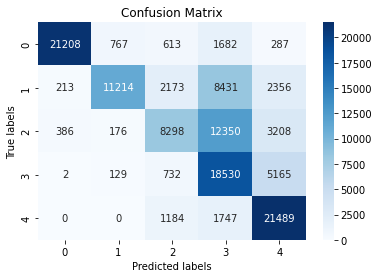

In [89]:
# Confusion matrix for the DecisionTree Classifier

import seaborn as sns

labels = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_predicted)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Blues', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [90]:
DT_cr = classification_report(y_test, y_predicted)
print(DT_cr)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     24557
           1       0.91      0.46      0.61     24387
           2       0.64      0.34      0.44     24418
           3       0.43      0.75      0.55     24558
           4       0.66      0.88      0.75     24420

    accuracy                           0.66    122340
   macro avg       0.72      0.66      0.66    122340
weighted avg       0.72      0.66      0.66    122340



In [91]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators=100,
                                min_impurity_decrease=0.01,
                                max_depth = 50)

RF_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_impurity_decrease=0.01)

In [92]:
y_predicted = RF_classifier.predict(X_test)

[[21207   859  1585   449   457]
 [  214 11522  6784  2732  3135]
 [  389   372 13666  5609  4382]
 [    2   148  8433 10339  5636]
 [    0     0  2139     0 22281]]


[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

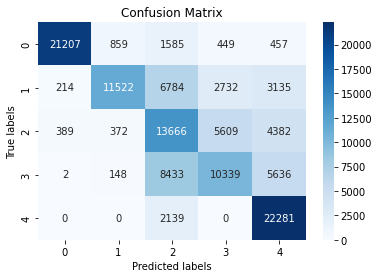

In [94]:
# Confusion matrix for the RandomForest Classifier

import seaborn as sns

labels = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_predicted)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Blues', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [95]:
RF_cr = classification_report(y_test, y_predicted)
print(RF_cr)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     24557
           1       0.89      0.47      0.62     24387
           2       0.42      0.56      0.48     24418
           3       0.54      0.42      0.47     24558
           4       0.62      0.91      0.74     24420

    accuracy                           0.65    122340
   macro avg       0.69      0.65      0.64    122340
weighted avg       0.69      0.65      0.64    122340



In [96]:
df_impt = pd.DataFrame({'features': X_train.columns,'importance': RF_classifier.feature_importances_})
df_impt = df_impt.sort_values(by = 'importance', ascending = False)
df_impt

,features,importance
8,_source.consumer_consent_provided,0.396520
3,_source.product,0.251432
6,_source.sub_product,0.146658
0,_source.issue,0.142829
5,_source.submitted_via,0.059801
2,_source.consumer_disputed,0.002761
1,_source.state,0.000000
4,_source.company_response,0.000000
7,_source.timely,0.000000


In [97]:
# Number of trees
n_estimators = [50, 100, 200, 250]

# Maximum depth of trees
max_depth = [5, 10, 15]

# Minimum number of samples required to split a node
min_samples_split = [50, 100, 150, 200]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40, 50, 60]

# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [98]:
# Implementating RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Create an instance of the RandomForestClassifier
clf_rf = RandomForestClassifier()

# Random search
random_rf = RandomizedSearchCV(estimator = clf_rf,
                       param_distributions = param_dict,
                       cv = 5, 
                       verbose = 2, 
                       scoring = 'roc_auc',
                       n_iter = 5,
                       random_state = 0)

random_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=  34.1s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=  27.0s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=  29.4s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=  31.7s
[CV] END max_depth=5, min_samples_leaf=40, min_samples_split=100, n_estimators=250; total time=  31.2s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=  18.1s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=  18.1s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=  15.8s
[CV] END max_depth=10, min_samples_leaf=60, min_samples_split=150, n_estimators=100; total time=  15.7s
[CV] END 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [40, 50, 60],
                                        'min_samples_split': [50, 100, 150,
                                                              200],
                                        'n_estimators': [50, 100, 200, 250]},
                   random_state=0, scoring='roc_auc', verbose=2)

In [99]:
rf_optimal_model = random_rf.best_estimator_

In [100]:
y_pred_rf = rf_optimal_model.predict(X_test)

[[21208   930  1490   472   457]
 [  202 12580  5562  2908  3135]
 [  388   476 13484  5688  4382]
 [    2   150  7342 11429  5635]
 [    0     0  2139     0 22281]]


[Text(0, 0.5, '0'),
 Text(0, 1.5, '1'),
 Text(0, 2.5, '2'),
 Text(0, 3.5, '3'),
 Text(0, 4.5, '4')]

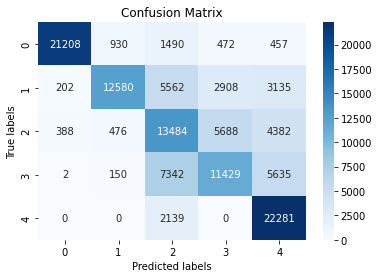

In [101]:
# Confusion matrix for the RandomForest Classifier

import seaborn as sns

labels = [0,1,2,3,4]
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, cmap = 'Blues', fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [102]:
RF_cr = classification_report(y_test, y_pred_rf)
print(RF_cr)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     24557
           1       0.89      0.52      0.65     24387
           2       0.45      0.55      0.50     24418
           3       0.56      0.47      0.51     24558
           4       0.62      0.91      0.74     24420

    accuracy                           0.66    122340
   macro avg       0.70      0.66      0.66    122340
weighted avg       0.70      0.66      0.66    122340



## Inference:

DecisionTree and RandomForest Classifiers incurred similar F1 scores for all classes but **Hyper-parameter tuned RF Classifier** has successfully improved the F1 scores of Class - 1,2 and 3.